# 初学者的 TensorFlow 2.0 教程

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://tensorflow.google.cn/tutorials/quickstart/beginner"><img src="https://tensorflow.google.cn/images/tf_logo_32px.png">在 TensorFlow.org 观看</a>   </td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/quickstart/beginner.ipynb"><img src="https://tensorflow.google.cn/images/colab_logo_32px.png">在 Google Colab 中运行 </a></td>
  <td>     <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/quickstart/beginner.ipynb"><img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png">在 GitHub 查看源代码</a>   </td>
  <td>     <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/tutorials/quickstart/beginner.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png">下载笔记本</a>   </td>
</table>

此简短介绍使用 [Keras](https://tensorflow.google.cn/guide/keras/overview) 进行以下操作：

1. 加载一个预构建的数据集。
2. 构建对图像进行分类的神经网络机器学习模型。
3. 训练此神经网络。
4. 评估模型的准确率。

## 设置 TensorFlow

首先将 TensorFlow 导入到您的程序：

In [15]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


## 加载数据集

加载并准备 [MNIST 数据集](http://yann.lecun.com/exdb/mnist/)。将样本数据从整数转换为浮点数：

In [2]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
print(x_train.shape)
print(y_train)

(60000, 28, 28)
[5 0 4 ... 5 6 8]


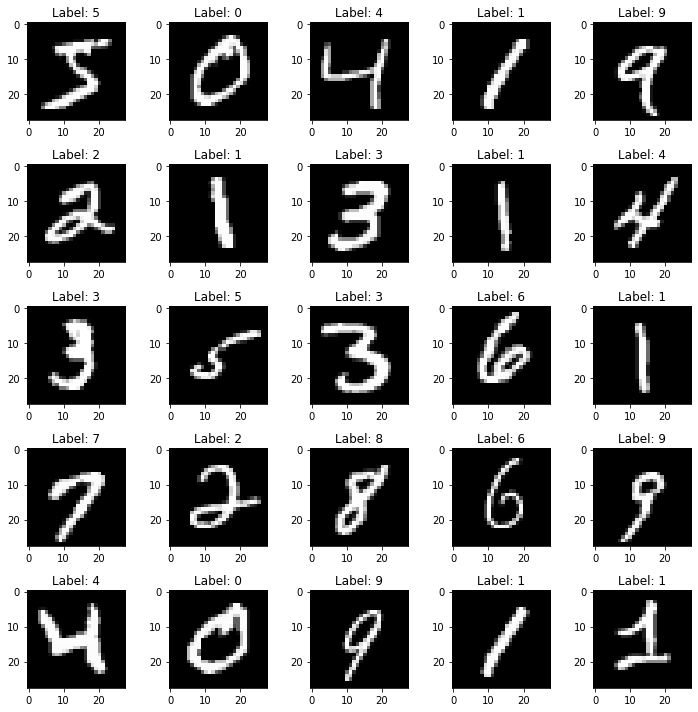

In [21]:
# 可视化前25个图像
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(10,10))
axs = axs.flatten() # flatten axes for circulation

for i in range(25):
    axs[i].
plt.imshow(x_train[i], cmap='gray')
    axs[i].set_title(f"Label: {y_train[i]}")

plt.tight_layout()
plt.show()

## 构建机器学习模型

通过堆叠层来构建 `tf.keras.Sequential` 模型。

In [3]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)), # 扁平序列
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10)
])

对于每个样本，模型都会返回一个包含 [logits](https://developers.google.com/machine-learning/glossary#logits) 或 [log-odds](https://developers.google.com/machine-learning/glossary#log-odds) 分数的向量，每个类一个。

>logits
The vector of raw (non-normalized) predictions that a classification model generates, which is ordinarily then passed to a normalization function. If the model is solving a multi-class classification problem, logits typically become an input to the softmax function. The softmax function then generates a vector of (normalized) probabilities with one value for each possible class.

> log_odds logarithm odds is the caculated as odds of success divide by odds of failure

`tf.nn.sigmoid_cross_entropy_with_logits.`

在TensorFlow中，logits是指模型最后一个隐藏层的输出，通常被认为是模型预测结果的原始值，而没有经过归一化或激活函数的处理。logits向量的每个元素都对应于模型预测为每个可能类别的“分数”，并且最大的分数通常被视为模型的最终预测结果。在训练过程中，我们将logits向量输入到交叉熵损失函数中，并计算出预测值和真实值之间的差距。在推断过程中，我们使用softmax函数将logits向量归一化，从而获得每个类别的概率分布。

In [7]:
predictions = model(x_train[:1]) # 注意此时模型参数随机，偏置项默认为0，此时为未训练状态
print(x_train[:1].shape)
print(predictions) # 输出分数

(1, 28, 28)
tf.Tensor(
[[-0.34886724 -0.03951162  0.39049232 -0.69959044 -0.02498347 -0.15935071
   0.24008913  0.34230092  0.90377814 -0.2758262 ]], shape=(1, 10), dtype=float32)


`tf.nn.softmax` 函数将这些 logits 转换为每个类的*概率*： 

In [10]:
print(y_train[:1])
tf.nn.softmax(predictions) # 输出概率

[5]


<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[0.06201171, 0.08449386, 0.12988932, 0.04366733, 0.08573037,
        0.0749514 , 0.11175173, 0.12377823, 0.21701548, 0.06671063]],
      dtype=float32)>

注：可以将 `tf.nn.softmax` 烘焙到网络最后一层的激活函数中。虽然这可以使模型输出更易解释，但不建议使用这种方式，因为在使用 softmax 输出时不可能为所有模型提供精确且数值稳定的损失计算。 

使用 `losses.SparseCategoricalCrossentropy` 为训练定义损失函数，它会接受 logits 向量和 `True` 索引，并为每个样本返回一个标量损失。

>`form_logits`参数是用来指示输入的y_pred是否已经是logits，即未经过softmax或sigmoid等激活函数处理的原始输出结果。
>1. 如果 from_logits 参数设置为 True，则假设输入的 y_pred 是未经过 softmax 归一化的 logits 值，该函数会自动对其进行 softmax 归一化处理。
>2. 如果 from_logits 参数设置为 False，则假设输入的 y_pred 已经经过了 softmax 归一化处理，那么该函数不会对其进行任何处理。

注意，即使 from_logits 参数设置为 True，也需要在模型的最后一层使用 activation='softmax' 参数对输出进行 softmax 归一化处理。如果在最后一层没有进行 softmax 归一化处理，那么就会出现在损失函数中使用 from_logits=True，但是在模型中没有进行 softmax 归一化处理的情况，这会导致最终的结果不正确。

>默认情况下，form_logits参数为False，因为在很多情况下，神经网络的输出已经经过softmax或sigmoid等激活函数处理，直接作为分类概率分布进行计算更为方便。如果y_pred是原始输出，即未经过激活函数处理的logits，那么需要将form_logits参数设置为True，以避免重复进行softmax或sigmoid等处理。

In [11]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

此损失等于 true 类的负对数概率：如果模型确定类正确，则损失为零。
这个未经训练的模型给出的概率接近随机（每个类为 1/10），因此初始损失应该接近 `-tf.math.log(1/10) ~= 2.3`。

In [12]:
loss_fn(y_train[:1], predictions).numpy()

2.5909154

在开始训练之前，使用 Keras `Model.compile` 配置和编译模型。将 [`optimizer`](https://tensorflow.google.cn/api_docs/python/tf/keras/optimizers) 类设置为 `adam`，将 `loss` 设置为您之前定义的 `loss_fn` 函数，并通过将 `metrics` 参数设置为 `accuracy` 来指定要为模型评估的指标。

In [13]:
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])
model.evaluate(x_test,  y_test, verbose=2) # 可以看到损失函数和精度都很差

313/313 - 0s - loss: 2.4072 - accuracy: 0.0981 - 483ms/epoch - 2ms/step


[2.4071903228759766, 0.09809999912977219]

## 训练并评估模型

使用 `Model.fit` 方法调整您的模型参数并最小化损失： 

In [14]:
model.fit(x_train, y_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.3005 - accuracy: 0.9135
Epoch 2/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1445 - accuracy: 0.9580
Epoch 3/5
1875/1875 [==============================] - 2s 974us/step - loss: 0.1069 - accuracy: 0.9675
Epoch 4/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0897 - accuracy: 0.9724
Epoch 5/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0760 - accuracy: 0.9765


`Model.evaluate` 方法通常在 "[Validation-set](https://developers.google.com/machine-learning/glossary#validation-set)" 或 "[Test-set](https://developers.google.com/machine-learning/glossary#test-set)" 上检查模型性能。

In [16]:
model.evaluate(x_test,  y_test, verbose=2)

313/313 - 0s - loss: 0.0694 - accuracy: 0.9775 - 170ms/epoch - 543us/step


[0.0694485455751419, 0.9775000214576721]

In [19]:
print(y_train[:1])
print(tf.nn.softmax(model(x_train[:1])))
model(x_train[:1])

[5]
tf.Tensor(
[[1.9383972e-11 1.7760367e-08 9.0908889e-09 1.4558725e-02 3.6680266e-15
  9.8544127e-01 4.3866473e-11 8.9830687e-10 8.8302268e-11 5.5643072e-09]], shape=(1, 10), dtype=float32)


<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[-12.089728 ,  -5.2694488,  -5.939147 ,   8.347282 , -20.662275 ,
         12.562181 , -11.273025 ,  -8.253662 , -10.573407 ,  -6.430046 ]],
      dtype=float32)>

现在，这个照片分类器的准确度已经达到 98%。想要了解更多，请阅读 [TensorFlow 教程](https://tensorflow.google.cn/tutorials/)。

**如果您想让模型返回概率，可以封装经过训练的模型，并将 softmax 附加到该模型：**

In [ ]:
probability_model = tf.keras.Sequential([
  model, # 使用封装好的模型
  tf.keras.layers.Softmax()
])

In [ ]:
probability_model(x_test[:5])

In [ ]:
model.summary()